# Australian Geoscience Datacube API
Generate statistics over a range of time, or by seasons.

In [4]:
!datacube-config check


Host: 130.56.244.227:5432
Database: dev
User: cube_user


Attempting connect
Success.


In [1]:
%matplotlib inline
from pprint import pprint
import numpy as np
import xarray.ufuncs

import datacube.api

In [2]:
dc = datacube.api.API()

In [5]:
data = dc.get_data_array(platform='LANDSAT_5', product='NBAR', y=(-34.00,-35.05), x=(148.95,149.05))
data

<xarray.DataArray u'ls5_nbar_albers' (variable: 6, time: 187, y: 4685, x: 983)>
dask.array<concate..., shape=(6, 187, 4685, 983), dtype=float64, chunksize=(1, 1, 3443, 983)>
Coordinates:
  * time      (time) datetime64[ns] 1990-03-02T23:11:16 1990-03-02T23:11:39 ...
  * y         (y) float64 -3.814e+06 -3.814e+06 -3.814e+06 -3.814e+06 ...
  * x         (x) float64 1.538e+06 1.538e+06 1.538e+06 1.538e+06 1.538e+06 ...
  * variable  (variable) <U7 u'band_10' u'band_20' u'band_30' u'band_40' ...

In [6]:
data = data.chunk({'time':182})
data.chunks

((1, 1, 1, 1, 1, 1), (182, 5), (3443, 1242), (983,))

In [7]:
nan_sum = data.sum(dim='time', skipna=True)

In [8]:
vld_obs = xarray.ufuncs.isfinite(data).sum(dim='time')

In [9]:
mean = nan_sum / vld_obs

In [10]:
residuals = data - mean

In [11]:
res_sq = residuals**2

### Masking with Pixel Quality Data

In [12]:
pq = dc.get_data_array(platform='LANDSAT_5', product='PQ', y=(-34.95,-35.05), x=(148.95,149.05), set_nan=False)
pq = pq.squeeze('variable')
pq

<xarray.DataArray u'ls5_pq_albers' (time: 181, y: 489, x: 420)>
dask.array<getitem..., shape=(181, 489, 420), dtype=int16, chunksize=(27, 489, 420)>
Coordinates:
  * time      (time) datetime64[ns] 1990-03-02T23:11:16 1990-03-02T23:11:39 ...
  * y         (y) float64 -3.919e+06 -3.919e+06 -3.919e+06 -3.919e+06 ...
  * x         (x) float64 1.538e+06 1.538e+06 1.538e+06 1.538e+06 1.538e+06 ...
    variable  <U17 u'band_pixelquality'

In [13]:
cloud_free = (pq^16383).astype('bool')

### Seasonal statistics
The `xarray.DataArray` objects provide Pandas-style indexing, including `groupby`.

In [14]:
red = data.sel(variable='band_30').where(cloud_free)
nir = data.sel(variable='band_40').where(cloud_free)

ValueError: Chunks do not align set([(27, 31, 25, 27, 28, 22, 21), (176, 5)])

In [15]:
ndvi = (nir - red) / (nir + red)
ndvi_seasons = ndvi.groupby('time.season')

NameError: name 'nir' is not defined

In [14]:
ndvi_seasonal_mean = ndvi_seasons.mean('time', skipna=True)

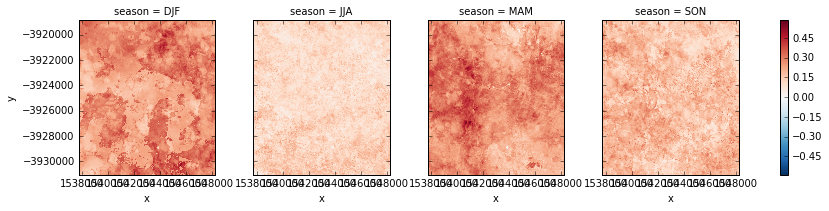

In [15]:
ndvi_seasonal_mean.plot(col='season')